In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
#%pip install torch torchvision
# You might want to install the gpu version when working on larger datasets in computer vision or NLP domains.
import torch
import torch.nn as nn #this submodule provides tools for building and training neural networks
import torch.optim as optim #this submodule contains information on optimizers such as SGD
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

In [2]:
housing = pd.read_csv("housing.csv")
X = housing.copy().drop(["ocean_proximity"], axis=1)
Y = housing.copy()["ocean_proximity"]
Y = housing.copy()["ocean_proximity"].map({"<1H OCEAN":0, "INLAND":1,
                                        "ISLAND": 2, "NEAR BAY": 3,
                                        "NEAR OCEAN": 4}).values

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    train_size=0.8, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,
                                                  test_size=0.2, train_size=0.8,
                                                  random_state=42)

In [5]:
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_dev = imputer.transform(X_dev)
X_test = imputer.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

In [6]:
# Create DataLoader for batching
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_data = TensorDataset(torch.tensor(X_dev), torch.tensor(y_dev))
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
def create_model(hidden_size, learning_rate, shape, optimi):
    l = []
    for _ in range(hidden_size):
        
        l.append(nn.Linear(shape, shape))
        l.append(nn.ReLU())
    m = nn.Sequential(
        nn.Linear(9, shape),
        *l,
        nn.Linear(shape, 5)
    )
    if optimi == 'sgd':
        optimizer = optim.SGD(m.parameters(), lr=learning_rate)
    elif optimi == 'adam':
        optimizer = optim.Adam(m.parameters(), lr=learning_rate)
    elif optimi == 'adamw':
       optimizer = optim.AdamW(m.parameters(), lr=learning_rate, weight_decay=1e-4)

    return m, optimizer

In [70]:
def train_and_val(model, optimizer, model_name, num_epochs=5, train_loader=train_loader, val_loader=val_loader, verbose=False):
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        train_loss_pe = pd.DataFrame(columns=['epoch', 'loss'])

        # Training step
        for inputs, labels in train_loader:
            inputs = inputs.float().to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Output is a single logit per sample
            train_loss = criterion(outputs,labels)
            train_loss.backward()
            optimizer.step()
            
            running_loss += train_loss.item()
            predicted = torch.softmax(outputs, dim=1) # Apply softmax to logits and classify
            predicted = torch.argmax(predicted, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            

        train_epoch_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        train_losses.append(train_epoch_loss)

            
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_running = 0.0
        val_correct = 0
        val_total = 0
        val_loss_pe = {}

        with torch.no_grad():  # Disable gradient computation for validation
            for inputs, labels in val_loader:
                inputs = inputs.float().to(device)
                labels = labels.long().to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs,labels)
                val_running += val_loss.item()
                predicted = torch.softmax(outputs, dim=1) # Apply softmax to logits and classify
                predicted = torch.argmax(predicted, dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
                    
        val_epoch_loss = val_running / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)
                

        # Record the losses
        # history['epoch'].append(epoch + 1)
        # history['train_loss'].append(train_loss.item())
        # history['val_loss'].append(val_loss.item())


        # Print losses every 10 epochs
    #     if (epoch + 1) % 10 == 0:
    #         print(f"Epoch [{epoch+1}/{num_epochs}], "
    #             f"Train Loss: {train_loss.item():.4f}, "
    #             f"Train Accuracy: {train_accuracy:.4f}, "
    #             f"Validation Loss: {val_loss.item():.4f}, "
    #             f"Validation Accuracy: {val_accuracy:.4f}")

    # # Print final losses after training
    # print(f"Final Train Loss: {train_loss:.4f}")
    # print(f"Final Validation Loss: {val_loss:.4f}")
    # print(f"Final Validation Accuracy: {val_accuracy:.4f}")
    
 # clear ambiguity and return consistent types
    if verbose:
        loss_df = pd.DataFrame({
            'epoch': list(range(1, num_epochs + 1)),
            'train_loss': train_losses,
            'val_loss': val_losses,
            'val_acc': val_accuracies
        })
        torch.save(model.state_dict(), f"{model_name}.pth")
        return loss_df

    else:
        return train_epoch_loss, val_epoch_loss, val_accuracy    
    

In [47]:
torch.manual_seed(42)  # PyTorch random seed

In [ ]:
from tqdm import tqdm
hidden_sizes = [1, 2, 3, 4, 5]
shape = [16,32,64]
learning_rates = [0.01, 0.001, 0.0001]
optimizers = ['sgd', 'adam', 'adamw']
models = pd.DataFrame(columns=['model', 'train_error', 'val_error', 'val_acc', 'optimizer', 'lr', 'hidden_size', 'shape'])
total_iterations = len(hidden_sizes) * len(shape) * len(learning_rates) * len(optimizers)

with tqdm(total=total_iterations, desc="Training Models") as pbar:
    for a in hidden_sizes:
        for b in shape:
            for c in learning_rates:
                for d in optimizers:
                    model, optimizer = create_model(a, c, b, d)
                    model.to(device)
                    m_name = f'model_h{a}_s{b}_lr{c}_{d}'
                    pbar.set_postfix_str(f"Running {m_name}")   # <-- replaces print()
                    t_loss, v_loss, v_acc = train_and_val(model, optimizer, m_name)
                    models.loc[len(models)] = [m_name, t_loss, v_loss, v_acc,  d, c, a, b]
                    pbar.update(1)


Training Models: 100%|██████████| 135/135 [46:42<00:00, 20.76s/it, Running model_h5_s64_lr0.0001_adamw]


In [57]:
models.head()

,model,train_error,val_error,val_acc,optimizer,lr,hidden_size,shape
0,model_h1_s16_lr0.01_sgd,0.237485,0.239950,0.905238,sgd,0.010,1,16
1,model_h1_s16_lr0.01_adam,0.219070,0.216121,0.919467,adam,0.010,1,16
2,model_h1_s16_lr0.01_adamw,0.203800,0.175489,0.925825,adamw,0.010,1,16
3,model_h1_s16_lr0.001_sgd,0.506966,0.509439,0.795035,sgd,0.001,1,16
4,model_h1_s16_lr0.001_adam,0.211103,0.203692,0.912807,adam,0.001,1,16


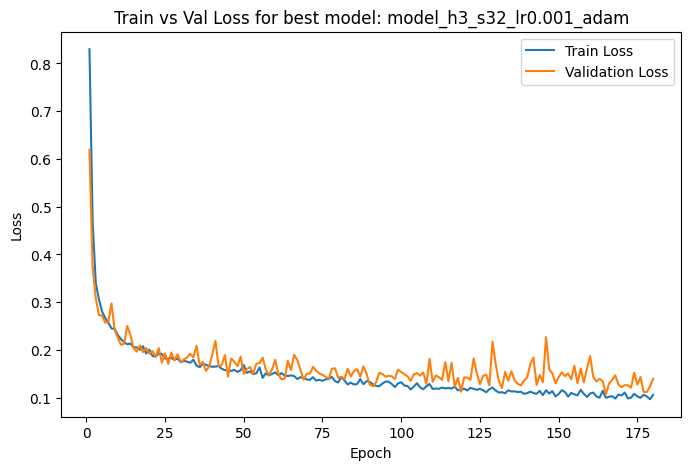

In [71]:
best_idx = models['val_acc'].idxmax()
best_row = models.loc[best_idx]

best_hidden = int(best_row['hidden_size'])
best_lr = float(best_row['lr'])
best_shape = int(best_row['shape'])
best_opt = best_row['optimizer']
best_name = best_row['model']

best_model, best_optimizer = create_model(best_hidden, best_lr, best_shape, best_opt)
best_model.to(device)

# retrain with verbose=True to collect per-epoch losses (returns DataFrame)
loss_df = train_and_val(best_model, best_optimizer, model_name=best_row['model'], num_epochs=180, verbose=True)

# plot
plt.figure(figsize=(8,5))
plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Train Loss')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Train vs Val Loss for best model: {best_name}')
plt.legend()
plt.show()

In [74]:
with torch.no_grad():
    logits = best_model(torch.tensor(X_test).float())
    preds = torch.softmax(logits, dim=1) # Apply softmax to logits and classify
    preds = torch.argmax(preds, dim=1)    
    accuracy = (preds == torch.tensor(y_test)).float().mean()
    print(f"Accuracy: {accuracy.item():.4f}")

Accuracy: 0.9479
